# HOMEWORK 2 :Local search approches & Constraint satisfaction Problem


## EXERCICE 1 : Problem B. Genetic Algorithm for Solving the Knapsack Problem

In [11]:
import pandas as pd

it = pd.read_csv('items.csv',sep = ";")
weights = it['weight'].values
values = it['value'].values
num_items = len(weights)
print (num_items)



500


We start our problerm by simply load the data and as it has only two columns we can put them one two different variable to simplyfy their use.
Last line is here just to het some information about the dataset and the number of elements

### Begining of the GA algorithms

Now the real business starts, We have to implement the different functions to assure that it will works properly.

In [12]:
import random
import time
import matplotlib.pyplot as plt

def fitness(individual):
    total_weight = np.sum(individual * weights)
    total_value = np.sum(individual * values)
    if total_weight > 10000:
        return 0  
    else:
        return total_value


Fist I implemented the fitness function. In our case individual is a possible solution. Basicaly it's an array composed of 1 and 0, 1 if the item is included in the solution and 0 if not. Then we get the total weights and the total value of the solution by making the sum of each columns of the dataset and individual. To get the score I decided to check if the solution is admissible and to give to the solution the score of it's total_value. The higher it is the better. We penalize the solution that exceed 10 000 by giving it the score of 0

In [13]:
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        individual = np.random.randint(2,size = num_items)
        population.append(individual)
    return population

This function is here to build our initial population. To do so we give it as a parameter the size we want to our population. We need a number large enought to be precise but small enought to optimize the time of working. In the for loop we create each individual by choosing randomly 0 or 1 and this 500 times, the number of items possible. We then add this individual to the array population.

In [14]:
def roulette_wheel_selection(population, fitnesses):
    total_fitness = np.sum(fitnesses)
    if total_fitness== 0 :
        selection_probs = np.full(len(population), 1 / len(population))
    else:
        selection_probs = fitnesses / total_fitness
    return population[np.random.choice(len(population), p=selection_probs)]


Here we define our first function to select the agent that can reproduce for the next generation. The roulette weel selection give a bigger importance to the individual with a bigger fitness score. I had some issue saying that i was dividing by 0. To counter that if the total_fitness is 0 (most likely before the first gen) I give an equal chance for everyone. While doing my research i discover the numpy function np.full that is perfect for our problem. Then we randomly choose the new population by "spinning" the wheel.

In [15]:
def tournament_selection(population, fitnesses, k=3):
    selected = np.random.choice(len(population), k)
    best = selected[np.argmax(fitnesses[selected])]
    return population[best]


The secound selection method is the tournament one. k is the number of opponent at each iteration. So here every iteration 3 individuals are selected and their fitness score is compared The best one is selected and put in the next generation.

In [16]:
def single_point_crossover(parent1, parent2):
    point = np.random.randint(1, num_items - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2


Now the crossover functions, The single point one is quite easy. It select randomly a point froint the index 1 and num_items -1 to ensure that at least one element is in each array. Then we create the two children by concatenating the genotype from the parents spliting in the point. The two children has by definition an inverted genotype.

In [17]:
def uniform_crossover(parent1, parent2):
    mask = np.random.randint(0, 2, size=num_items)
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2


For this one it is a little bit more complex. We create an array of 0 and 1 called mask. then we use the numpy function np.where to create our two children. If the mask has a 1 one a given index it will take the first parameter between parent1 and parent2, (reverse for 0). Therefore out two children have an reversed genotype. when one has a 1 the other has 0

In [18]:
def mutate(individual, mutation_rate):
    for i in range(num_items):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]  
    return individual


We defined our mutation function. For each element of our individual we randomly ckeck a number if it is smaller that a given mutation rate then we switch the value of the element.

To go further on the exercice and be more accurate I've chosen to put more selection and crossover algorithms

In [19]:
def two_point_crossover(parent1, parent2):
    point1 = np.random.randint(1, num_items - 2)
    point2 = np.random.randint(point1 + 1, num_items - 1)
    child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
    child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
    return child1, child2


This one uses the same principle than the single point crossover but we divide the children two times.

In [20]:
def n_point_crossover(parent1, parent2, n=3):
    points = sorted(np.random.choice(range(1, num_items - 1), n, replace=False))
    child1,child2 = parent1.copy(), parent2.copy()
    swap = False
    current_index = 0
    for point in points + [num_items]:
        if swap:
            child1[current_index:point], child2[current_index:point] = (
                child2[current_index:point],
                child1[current_index:point],
            )
        swap = not swap
        current_index = point
    return child1, child2


To generralize it to a n_point method where the children are splited n times. Here I chose 3 but it can be more

In [21]:
def truncation_selection(population, fitnesses, truncation_rate=0.5):
    num_to_select = int(len(population) * truncation_rate)
    sorted_indices = np.argsort(-fitnesses)
    truncated_population = [population[i] for i in sorted_indices[:num_to_select]]
    return random.choice(truncated_population)


This selection method simply choose the population by truncating depending of the fitness score. We select the 50% best output and then we select our new population from it

In [22]:
def rank_selection(population, fitnesses):
    sorted_indices = np.argsort(fitnesses)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(fitnesses))
    total_rank = np.sum(ranks + 1)
    selection_probs = (ranks + 1) / total_rank
    return population[np.random.choice(len(population), p=selection_probs)]


In [23]:
population_size = 100
num_generations = 2000
mutation_rate = 0.01
crossover_rate = 0.8


Here are our GA parameters. 

In [24]:

def genetic_algorithm(selection_func, crossover_func):
    start_time = time.time()
    population = generate_initial_population(population_size)
    best_fitness_history = []
    best_solution = None
    best_fitness_value = 0

    for generation in range(num_generations):
        fitnesses = np.array([fitness(ind) for ind in population])

        
        max_fitness = np.max(fitnesses)
        if max_fitness > best_fitness_value:
            best_fitness_value = max_fitness
            best_solution = population[np.argmax(fitnesses)]

        best_fitness_history.append(best_fitness_value)

        new_population = []

        while len(new_population) < population_size:
            
            parent1 = selection_func(population, fitnesses)
            parent2 = selection_func(population, fitnesses)

           
            if random.random() < crossover_rate:
                child1, child2 = crossover_func(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()

            
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)

            new_population.extend([child1, child2])

        population = new_population[:population_size]


    end_time = time.time()
    runtime = end_time - start_time
    print(f"Best Fitness = {best_fitness_value}")
    return best_solution, best_fitness_value, best_fitness_history, runtime


This function is the main one of the problem. It start by the initialization of the different parameters.
Then we have a for loop to guarantee the number of generations of the problem. A little part of the code save the best fitness of the current generation an dadd it to the history of best fitnesses. The while loop is here to make sure the next generation will have the same amount of individuals. Now the selection, the crossover and mutation are used.

### Testing and Comparaisons

This part will show the different combinaison of selection and crossover function in our algorithm

In [25]:
best_sol_rw_sp, best_fit_rw_sp, fit_history_rw_sp, runtime_rw_sp = genetic_algorithm(
    selection_func=roulette_wheel_selection,
    crossover_func=single_point_crossover
)


Best Fitness = 25249


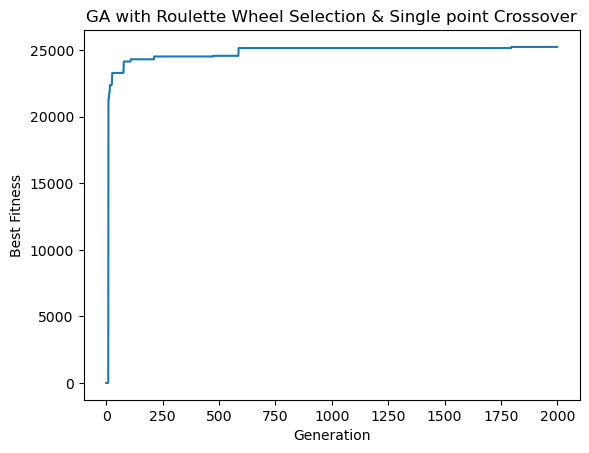

In [26]:
plt.plot(fit_history_rw_sp)
plt.title('GA with Roulette Wheel Selection & Single point Crossover')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [27]:
best_sol_tour_uni, best_fit_tour_uni, fit_history_tour_uni, runtime_tour_uni = genetic_algorithm(
    selection_func=tournament_selection,
    crossover_func=uniform_crossover
)


Best Fitness = 21691


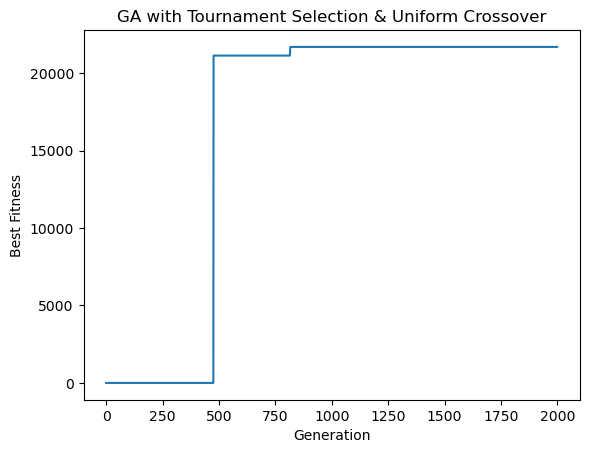

In [28]:
plt.plot(fit_history_tour_uni)
plt.title('GA with Tournament Selection & Uniform Crossover')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()


In [29]:
best_sol_tour_sp, best_fit_tour_sp, fit_history_tour_sp, runtime_tour_sp = genetic_algorithm(
    selection_func=tournament_selection,
    crossover_func=single_point_crossover
)

Best Fitness = 21533


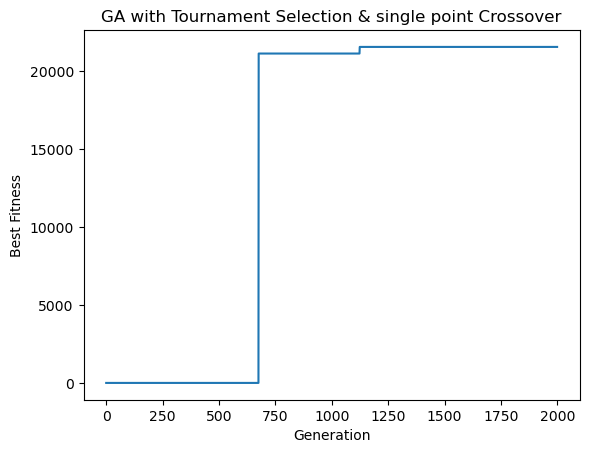

In [30]:
plt.plot(fit_history_tour_sp)
plt.title('GA with Tournament Selection & single point Crossover')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [31]:
best_sol_rw_uni, best_fit_rw_uni, fit_history_rw_uni, runtime_rw_uni = genetic_algorithm(
    selection_func=roulette_wheel_selection,
    crossover_func=uniform_crossover
)

Best Fitness = 24809


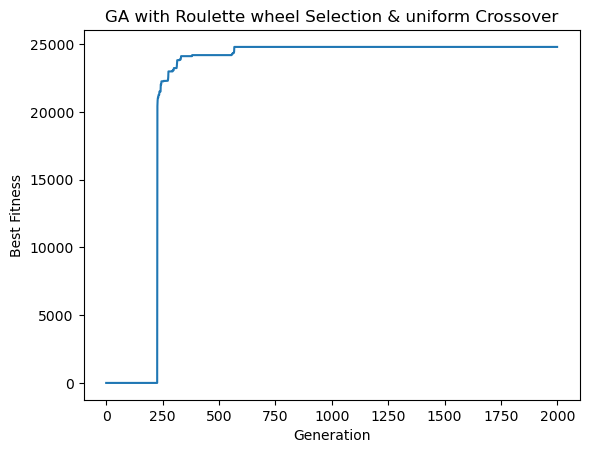

In [32]:
plt.plot(fit_history_rw_uni)
plt.title('GA with Roulette wheel Selection & uniform Crossover')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

From now we will stop ploting the result individually wi will do so at the end on the same plot

In [33]:
best_sol_rw_tp, best_fit_rw_tp, fit_history_rw_tp, runtime_rw_tp = genetic_algorithm(
    selection_func=roulette_wheel_selection,
    crossover_func=two_point_crossover
)

Best Fitness = 25625


In [34]:
best_sol_rw_np, best_fit_rw_np, fit_history_rw_np, runtime_rw_np = genetic_algorithm(
    selection_func=roulette_wheel_selection,
    crossover_func=n_point_crossover
)

Best Fitness = 24099


In [35]:
best_sol_to_np, best_fit_to_np, fit_history_to_np, runtime_to_np = genetic_algorithm(
    selection_func=tournament_selection,
    crossover_func=n_point_crossover
)

Best Fitness = 31079


In [36]:
best_sol_to_tp, best_fit_to_tp, fit_history_to_tp, runtime_to_tp = genetic_algorithm(
    selection_func=tournament_selection,
    crossover_func=two_point_crossover
)

Best Fitness = 30858


In [37]:
best_sol_ts_tp, best_fit_ts_tp, fit_history_ts_tp, runtime_ts_tp = genetic_algorithm(
    selection_func=truncation_selection,
    crossover_func=two_point_crossover
)

Best Fitness = 21897


In [38]:
best_sol_ts_sp, best_fit_ts_sp, fit_history_ts_sp, runtime_ts_sp = genetic_algorithm(
    selection_func=truncation_selection,
    crossover_func=single_point_crossover
)

Best Fitness = 22147


In [39]:
best_sol_ts_uni, best_fit_ts_uni, fit_history_ts_uni, runtime_ts_uni = genetic_algorithm(
    selection_func=truncation_selection,
    crossover_func=uniform_crossover
)

Best Fitness = 21325


In [40]:
best_sol_ts_np, best_fit_ts_np, fit_history_ts_np, runtime_ts_np = genetic_algorithm(
    selection_func=truncation_selection,
    crossover_func=n_point_crossover
)

Best Fitness = 29755


In [41]:
best_sol_rs_tp, best_fit_rs_tp, fit_history_rs_tp, runtime_rs_tp = genetic_algorithm(
    selection_func=rank_selection,
    crossover_func=two_point_crossover
)

Best Fitness = 22960


In [42]:
best_sol_rs_sp, best_fit_rs_sp, fit_history_rs_sp, runtime_rs_sp = genetic_algorithm(
    selection_func=rank_selection,
    crossover_func=single_point_crossover
)

Best Fitness = 22513


In [43]:
best_sol_rs_uni, best_fit_rs_uni, fit_history_rs_uni, runtime_rs_uni = genetic_algorithm(
    selection_func=rank_selection,
    crossover_func=uniform_crossover
)

Best Fitness = 20878


In [44]:
best_sol_rs_np, best_fit_rs_np, fit_history_rs_np, runtime_rs_np = genetic_algorithm(
    selection_func=rank_selection,
    crossover_func=n_point_crossover
)

Best Fitness = 0


In [45]:
def greedy_algorithm():
    start_time = time.time()

    ratio = values / weights
    indices = np.argsort(-ratio)  
    total_weight = 0
    total_value = 0
    solution = np.zeros(num_items, dtype=int)

    for i in indices:
        if total_weight + weights[i] <= 10000:
            solution[i] = 1
            total_weight += weights[i]
            total_value += values[i]

    end_time = time.time()
    runtime = end_time - start_time
    return solution, total_value, runtime


For my greedy algorithm, I have chosen a simple approach. I calculated a ratio to know wich items are the most interresting then i sort my list depending of those ratio. Then I add the items to the list if they respect the conditions of not getting over the maximal weight. It is quite simple and might be close to the optimal solution but I doubght it will be the best possible.

In [46]:
greedy_solution, greedy_value, greedy_runtime = greedy_algorithm()
print(f"Greedy Algorithm Total Value: {greedy_value}")


Greedy Algorithm Total Value: 35517


The value is pretty hight in comparaison of the others method, let's check it  by plotting to visualize it.

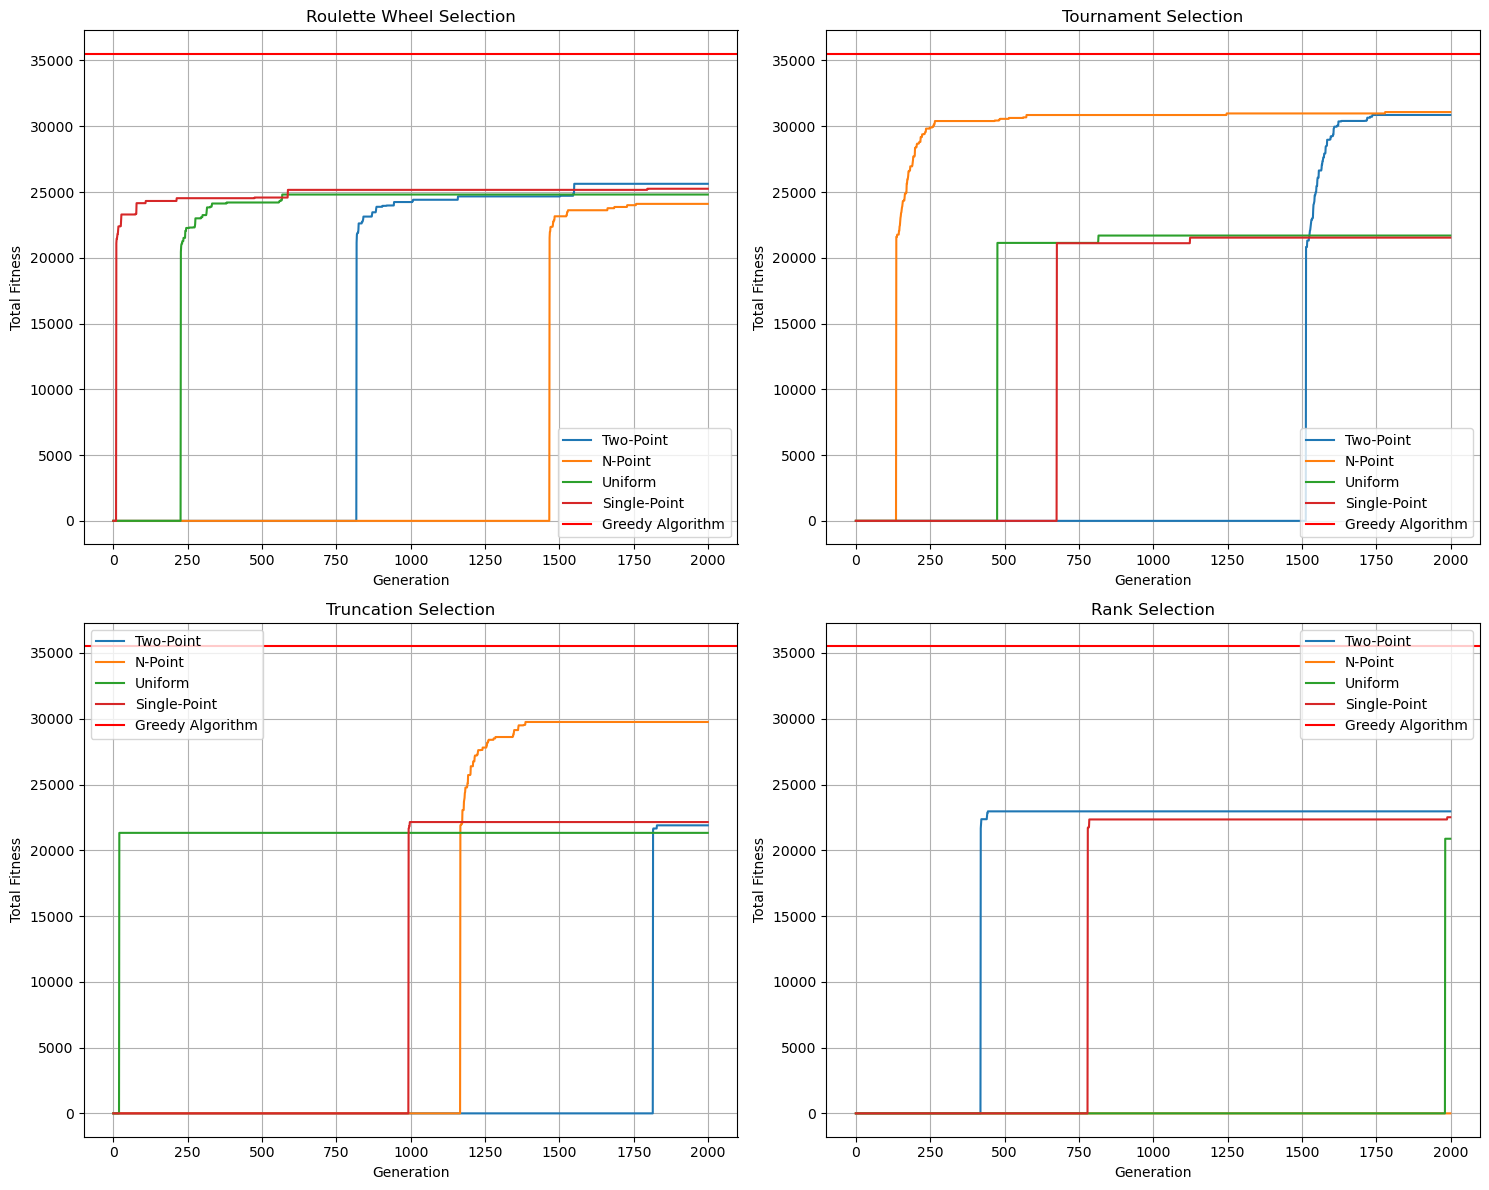

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

#1. Roulette Wheel Selection 
axs[0, 0].plot(fit_history_rw_tp, label='Two-Point', linestyle='-')
axs[0, 0].plot(fit_history_rw_np, label='N-Point', linestyle='-')
axs[0, 0].plot(fit_history_rw_uni, label='Uniform', linestyle='-')
axs[0, 0].plot(fit_history_rw_sp, label='Single-Point', linestyle='-')
axs[0, 0].axhline(y=greedy_value, color='red', linestyle='-', label='Greedy Algorithm')
axs[0, 0].set_title('Roulette Wheel Selection')
axs[0, 0].set_xlabel('Generation')
axs[0, 0].set_ylabel('Total Fitness')
axs[0, 0].legend()
axs[0, 0].grid(True)

#2. Tournament Selection 
axs[0, 1].plot(fit_history_to_tp, label='Two-Point', linestyle='-')
axs[0, 1].plot(fit_history_to_np, label='N-Point', linestyle='-')
axs[0, 1].plot(fit_history_tour_uni, label='Uniform', linestyle='-')
axs[0, 1].plot(fit_history_tour_sp, label='Single-Point', linestyle='-')
axs[0, 1].axhline(y=greedy_value, color='red', linestyle='-', label='Greedy Algorithm')
axs[0, 1].set_title('Tournament Selection')
axs[0, 1].set_xlabel('Generation')
axs[0, 1].set_ylabel('Total Fitness')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Truncation Selection
axs[1, 0].plot(fit_history_ts_tp, label='Two-Point', linestyle='-')
axs[1, 0].plot(fit_history_ts_np, label='N-Point', linestyle='-')
axs[1, 0].plot(fit_history_ts_uni, label='Uniform', linestyle='-')
axs[1, 0].plot(fit_history_ts_sp, label='Single-Point', linestyle='-')
axs[1, 0].axhline(y=greedy_value, color='red', linestyle='-', label='Greedy Algorithm')
axs[1, 0].set_title('Truncation Selection')
axs[1, 0].set_xlabel('Generation')
axs[1, 0].set_ylabel('Total Fitness')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. Rank Selection
axs[1, 1].plot(fit_history_rs_tp, label='Two-Point', linestyle='-')
axs[1, 1].plot(fit_history_rs_np, label='N-Point', linestyle='-')
axs[1, 1].plot(fit_history_rs_uni, label='Uniform', linestyle='-')
axs[1, 1].plot(fit_history_rs_sp, label='Single-Point', linestyle='-')
axs[1, 1].axhline(y=greedy_value, color='red', linestyle='-', label='Greedy Algorithm')
axs[1, 1].set_title('Rank Selection')
axs[1, 1].set_xlabel('Generation')
axs[1, 1].set_ylabel('Total Fitness')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


ANALYSIS :

- Roulette wheel :
    We can see that for the roulette wheel selection all the different crossover slope have quite the same shape. There is just a translation on the x axis wich means that the mutation/ modification that is necessary to get a better score happen sooner
- Tournament selection :
    The Tournament selection seems to be the best option we have between the different selection method. All of them reachef a higher fitness score. For the uniform crossover we can see a two steps improvement that we don't see on the others. It is not gradually improving.
- Truncation selection :
    It is the most splitted one, some reache very quickly teir maximum value while other wait for almost the end to get an advance. Moreover 2 of the algo are almost as efficient as tournament but the other 2 are way less usefull.
- Rank selection :
    By far the less efficient one, all the algo are gathered and quickly they reach their maximum value.


In conclusion the convergence and the value differs significantly from one crossover method to the other and even more depending on the selection method. I have tried to put more initial population or more generation and we get slightly different results. If we had to much gen we get a horrific runtime but most of the solution are near the best possible.

In [48]:
runtimes_rw = [runtime_rw_tp, runtime_rw_np, runtime_rw_uni, runtime_rw_sp]
labels_rw = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
runtimes_tour = [runtime_to_tp, runtime_to_np, runtime_tour_uni, runtime_tour_sp]
labels_tour = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
runtimes_ts = [runtime_ts_tp, runtime_ts_np, runtime_ts_uni, runtime_ts_sp]
labels_ts = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
runtimes_rs = [runtime_rs_tp, runtime_rs_np, runtime_rs_uni, runtime_rs_sp]
labels_rs = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
runtime_greedy = greedy_runtime  

runtimes_rw = [runtime_rw_tp, runtime_rw_np, runtime_rw_uni, runtime_rw_sp]
labels_rw = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
average_runtime_rw = np.mean(runtimes_rw)

runtimes_tour = [runtime_to_tp, runtime_to_np, runtime_tour_uni, runtime_tour_sp]
labels_tour = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
average_runtime_tour = np.mean(runtimes_tour)

runtimes_ts = [runtime_ts_tp, runtime_ts_np, runtime_ts_uni, runtime_ts_sp]
labels_ts = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
average_runtime_ts = np.mean(runtimes_ts)

runtimes_rs = [runtime_rs_tp, runtime_rs_np, runtime_rs_uni, runtime_rs_sp]
labels_rs = ['Two-Point', 'N-Point', 'Uniform', 'Single-Point']
average_runtime_rs = np.mean(runtimes_rs)




C:\Users\asus\AppData\Local\Temp\ipykernel_4036\3190828075.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\asus\AppData\Local\Temp\ipykernel_4036\3190828075.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\asus\AppData\Local\Temp\ipykernel_4036\3190828075.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\asus\AppData\Local\Temp\ipykernel_4036\3190828075.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

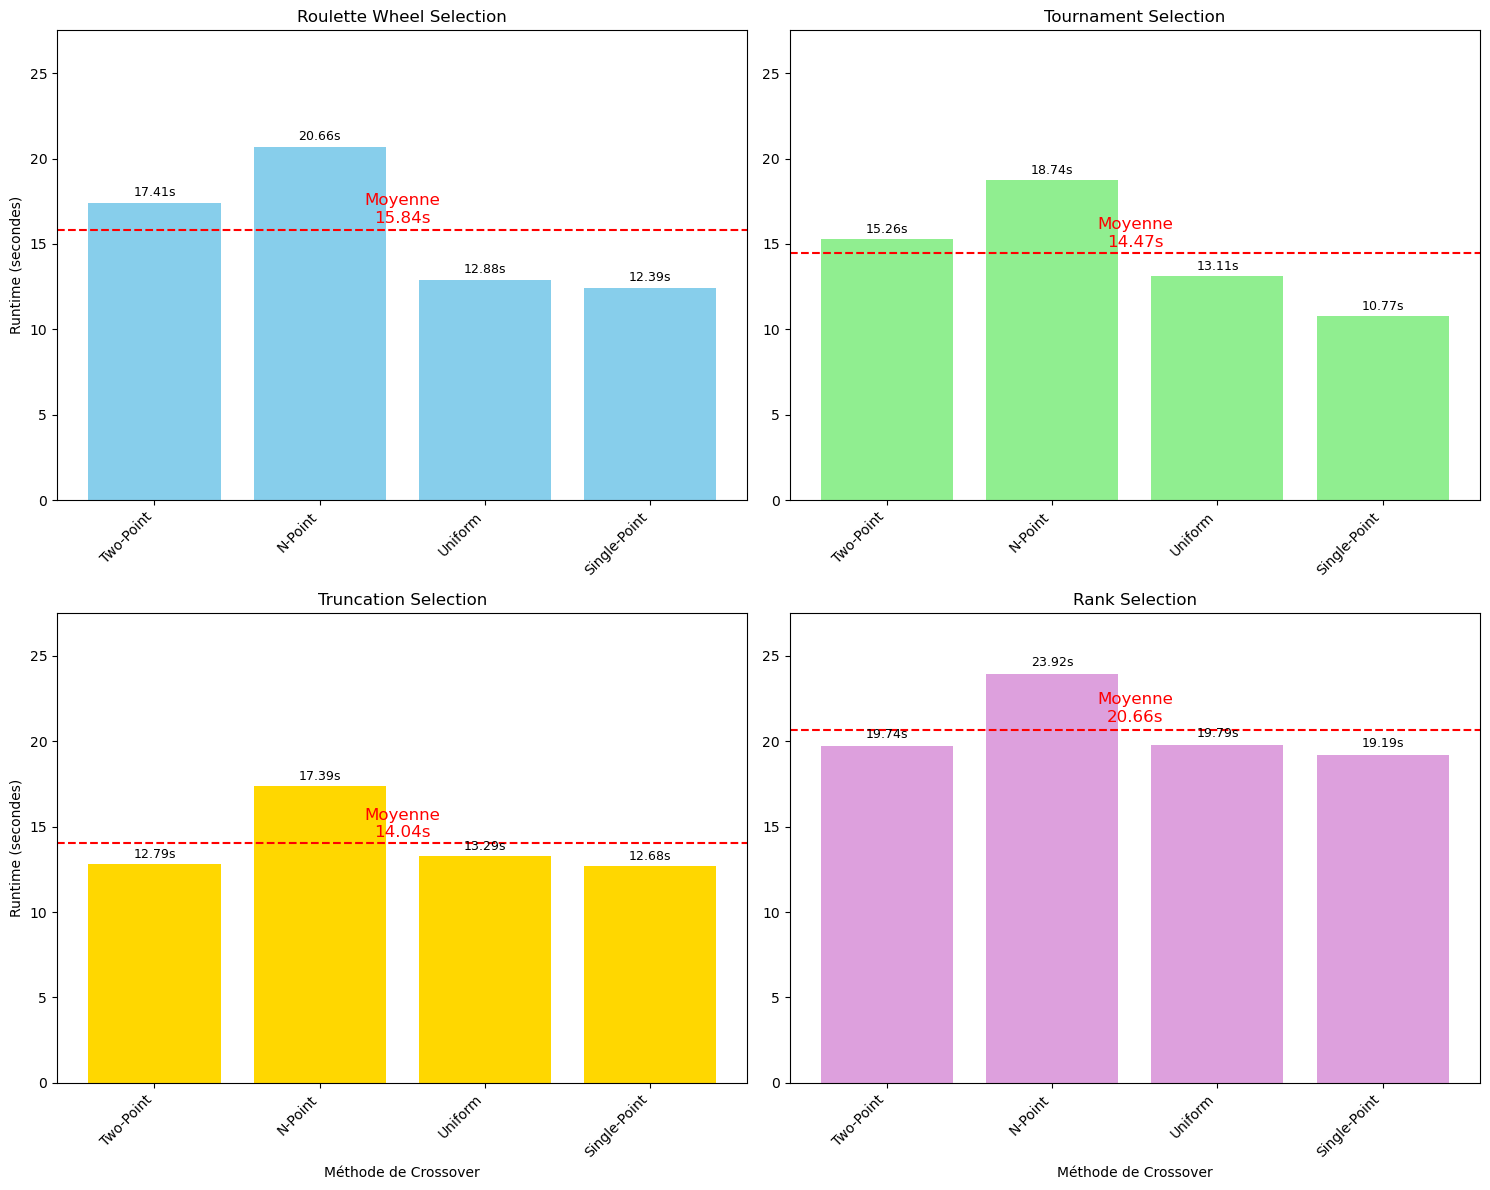

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

#1. Roulette Wheel Selection 
axs[0, 0].bar(labels_rw, runtimes_rw, color='skyblue')
axs[0, 0].set_title('Roulette Wheel Selection')
axs[0, 0].set_ylabel('Runtime (secondes)')

axs[0, 0].axhline(y=average_runtime_rw, color='red', linestyle='--')
axs[0, 0].text(1.5, average_runtime_rw + max(runtimes_rw) * 0.02, f"Moyenne\n{average_runtime_rw:.2f}s", color='red', fontsize=12, ha='center')

#2. Tournament Selection 
axs[0, 1].bar(labels_tour, runtimes_tour, color='lightgreen')
axs[0, 1].set_title('Tournament Selection')
axs[0, 1].axhline(y=average_runtime_tour, color='red', linestyle='--')


axs[0, 1].text(1.5, average_runtime_tour + max(runtimes_tour) * 0.02, f"Moyenne\n{average_runtime_tour:.2f}s", color='red', fontsize=12, ha='center')

#3. Truncation Selection
axs[1, 0].bar(labels_ts, runtimes_ts, color='gold')
axs[1, 0].set_title('Truncation Selection')
axs[1, 0].set_xlabel('Méthode de Crossover')
axs[1, 0].set_ylabel('Runtime (secondes)')
axs[1, 0].axhline(y=average_runtime_ts, color='red', linestyle='--')
axs[1, 0].text(1.5, average_runtime_ts + max(runtimes_ts) * 0.02, f"Moyenne\n{average_runtime_ts:.2f}s", color='red', fontsize=12, ha='center')

#4. Rank Selection
axs[1, 1].bar(labels_rs, runtimes_rs, color='plum')
axs[1, 1].set_title('Rank Selection')
axs[1, 1].set_xlabel('Méthode de Crossover')
axs[1, 1].axhline(y=average_runtime_rs, color='red', linestyle='--')
axs[1, 1].text(1.5, average_runtime_rs + max(runtimes_rs) * 0.02, f"Moyenne\n{average_runtime_rs:.2f}s", color='red', fontsize=12, ha='center')

for ax, runtimes in zip(axs.flat, [runtimes_rw, runtimes_tour, runtimes_ts, runtimes_rs]):
    for i, v in enumerate(runtimes):
        ax.text(i, v + max(runtimes) * 0.02, f"{v:.2f}s", ha='center', fontsize=9)


for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for ax in axs.flat:
    ax.set_ylim(0, max(runtimes_rw + runtimes_tour + runtimes_ts + runtimes_rs) * 1.15)

plt.tight_layout()
plt.show()


The runtime of the different algo is quite similar, the fastest is the truncation and the slowest the rank selection. For each of them the n-point method make the resolution longer but the fastest is the single point. When I add some generation or doubled the size of the initial population, the duration time was about 10 to 20 times longer.

In [50]:
algorithms = [
    ("Roulette Wheel Selection & Two-Point Crossover", best_sol_rw_tp),
    ("Roulette Wheel Selection & N-Point Crossover", best_sol_rw_np),
    ("Roulette Wheel Selection & Uniform Crossover", best_sol_rw_uni),
    ("Roulette Wheel Selection & Single-Point Crossover", best_sol_rw_sp),
    ("Tournament Selection & Two-Point Crossover", best_sol_to_tp),
    ("Tournament Selection & N-Point Crossover", best_sol_to_np),
    ("Tournament Selection & Uniform Crossover", best_sol_tour_uni),
    ("Tournament Selection & Single-Point Crossover", best_sol_tour_sp),
    ("Truncation Selection & Two-Point Crossover", best_sol_ts_tp),
    ("Truncation Selection & N-Point Crossover", best_sol_ts_np),
    ("Truncation Selection & Uniform Crossover", best_sol_ts_uni),
    ("Truncation Selection & Single-Point Crossover", best_sol_ts_sp),
    ("Rank Selection & Two-Point Crossover", best_sol_rs_tp),
    ("Rank Selection & N-Point Crossover", best_sol_rs_np),
    ("Rank Selection & Uniform Crossover", best_sol_rs_uni),
    ("Rank Selection & Single-Point Crossover", best_sol_rs_sp),
]

for name, best_solution in algorithms:
    if best_solution is None:
        print(f"For {name}:\nNo solution found. Best solution is None.\n")
        continue  
    sol_weight = np.sum(best_solution * weights)
    sol_value = np.sum(best_solution * values)
    selected_items_indices = np.where(best_solution == 1)[0]
    print(f"For {name}:")
    print(f"Number of items selected: {len(selected_items_indices)}")
    print(f"Final weight reached = {sol_weight}")
    print(f"Final value reached  = {sol_value}\n")
    

# For the greedy
greedy_weight = np.sum(greedy_solution * weights)
greedy_value = np.sum(greedy_solution * values)
selected_items_indices_greedy = np.where(greedy_solution == 1)[0]
print("For the Greedy Algorithm:")
print(f"Number of items selected: {len(selected_items_indices_greedy)}")
print(f"Final weight reached = {greedy_weight}")
print(f"Final value reached  = {greedy_value}\n")


For Roulette Wheel Selection & Two-Point Crossover:
Number of items selected: 233
Final weight reached = 9797
Final value reached  = 25625

For Roulette Wheel Selection & N-Point Crossover:
Number of items selected: 218
Final weight reached = 9860
Final value reached  = 24099

For Roulette Wheel Selection & Uniform Crossover:
Number of items selected: 232
Final weight reached = 9728
Final value reached  = 24809

For Roulette Wheel Selection & Single-Point Crossover:
Number of items selected: 233
Final weight reached = 9951
Final value reached  = 25249

For Tournament Selection & Two-Point Crossover:
Number of items selected: 265
Final weight reached = 9986
Final value reached  = 30858

For Tournament Selection & N-Point Crossover:
Number of items selected: 268
Final weight reached = 9938
Final value reached  = 31079

For Tournament Selection & Uniform Crossover:
Number of items selected: 211
Final weight reached = 9960
Final value reached  = 21691

For Tournament Selection & Single-Poi

In conclusion to this exercice, we can see that most of the algorithms get a solution exept for the rank/uniform that gets stuck to the begigning 3 times out of 5 try. As it is based on randomness we can get different result each time. It can be due to the mutation that occurs sooner on some try or maybe never happen. The tournament selection is in my opinion better in this contex. I tried it with 5 opponent (changed the k in the function definition) and it just improved the convergeance, the algo was faster to get to its top value but with 15 to 20 opponent we lost almost all of our fitness score. 

Our final results are far from the greedy one showing us that we can improve our model. The greedy algo was simple yet it is the most effective in the case. Maybe if there were more data to be counted of like the volume  or the importance, delivery time,... our algorithms would be out of use.

I

## EXERCICE 2 : Solving a 6×6 Battleship Solitaire Puzzle Using Constraint Satisfaction Problem (CSP)

### PRINCIPAUX DEFIS ET DIFFICULTES

**Problèmes de débogage:**
   - Le débogage du solveur a été l'un des aspects les plus chronophages de ce projet. Chaque fois que le programme ne parvenait pas à trouver une solution, l'identification de la cause première n'était pas évidente. La difficulté était d'autant plus grande que le placement des mouvements était aléatoire, ce qui rendait la reproduction des erreurs et l'isolement des bugs plus complexes.


2. **Implémentation des contraintes de placement des navires:**
   - Décider de ce qui était autorisé ou non pour le placement des navires impliquait de traduire soigneusement les règles du jeu en contraintes. Il s'agissait notamment de
     - S'assurer que les navires ne se touchent pas, même en diagonale.
     - Respecter le nombre de segments de lignes et de colonnes.
     - Gérer les contraintes relatives aux flottes, en veillant à ce que le nombre correct de chaque type de navire soit placé.
   - La difficulté consistait à s'assurer que toutes les contraintes fonctionnaient harmonieusement, sans effets secondaires imprévus.

3. **Globalisation des modifications du code:**
   - Un problème récurrent consistait à apporter des modifications au code pour résoudre un exemple spécifique, pour ensuite découvrir que ces modifications brisaient la fonctionnalité pour d'autres exemples. Cela m'a obligé à me concentrer sur la création de solutions qui fonctionnent dans tous les scénarios plutôt que dans des cas individuels. Les tests sur plusieurs grilles sont devenus essentiels pour vérifier l'exactitude du solveur.

4. **Corriger les erreurs mineures dans la base de code:**
   - Avec un grand nombre de lignes de code, même de petites erreurs (par exemple, des erreurs de décalage, des mises à jour de domaine incorrectes, des contraintes mal placées ou même un basculement erroné) peuvent causer des problèmes importants. Le suivi et la correction de ces erreurs mineures, en particulier lorsqu'elles ont des effets en cascade, requièrent une grande attention aux détails.



___



### Création de notre CSP

On commence par définir notre grille de départ et créer une méthode pour formater nos données dans un format manipulable par notre solveur. Pour cela j'ai créé une fonction qui lit les données, sépare les lignes d'informations et la grile en elle même.

In [25]:

input_data = """
221104
131212
3210
000000
000000
000000
0000S0
000000
000000
"""
N = 6
# Function to parse the input data
def parse_input(input_str):
    lines = input_str.strip().split('\n')
    row_constraints = [int(c) for c in lines[0]]
    col_constraints = [int(c) for c in lines[1]]
    fleet_counts = [int(c) for c in lines[2]]  # [Submarines, Destroyers, Cruisers, Battleships]
    grid = [list(line) for line in lines[3:]]
    return row_constraints, col_constraints, fleet_counts, grid

# Parse the input
row_constraints, col_constraints, fleet_counts, grid = parse_input(input_data)

# Display the parsed input
print("Row Constraints:", row_constraints)
print("Column Constraints:", col_constraints)
print("Fleet Counts (Submarines, Destroyers, Cruisers, Battleships):", fleet_counts)
print("Initial Grid:")
for row in grid:
    print(''.join(row))


Row Constraints: [2, 2, 1, 1, 0, 4]
Column Constraints: [1, 3, 1, 2, 1, 2]
Fleet Counts (Submarines, Destroyers, Cruisers, Battleships): [3, 2, 1, 0]
Initial Grid:
000000
000000
000000
0000S0
000000
000000


Créons maintenant une fonction pour que notre affichage soit plus lisible et joli.

In [26]:
def display_grid_with_constraints(grid, column_constraints, row_constraints):
    print("   " + " ".join(map(str, column_constraints)))
    print("  +" + "--" * len(column_constraints) + "+")  

    for i, row in enumerate(grid):
        row_str = " ".join(row)
        print(f"{row_constraints[i]} | {row_str} |")  

    print("  +" + "--" * len(column_constraints) + "+")  

    
    fleet_labels = ["Submarines (1 cell):", "Destroyers (2 cells):", "Cruisers (3 cells):", "Battleships (4 cells):"]
    for label, count in zip(fleet_labels, fleet_counts):
        print(f"{label} {count}")

display_grid_with_constraints(grid, col_constraints, row_constraints)

   1 3 1 2 1 2
  +------------+
2 | 0 0 0 0 0 0 |
2 | 0 0 0 0 0 0 |
1 | 0 0 0 0 0 0 |
1 | 0 0 0 0 S 0 |
0 | 0 0 0 0 0 0 |
4 | 0 0 0 0 0 0 |
  +------------+
Submarines (1 cell): 3
Destroyers (2 cells): 2
Cruisers (3 cells): 1
Battleships (4 cells): 0


Passons maintenant à l'implémentation de notre CSP et pour cela il va falloir commencer par définir les domaines des variables ,c'est à dire toutes les valeurs qu'elle pouront prendre (eau,proue,milieu bateau,...). Ensuite on va chercher quelles sont les valeurs à assigner et donc les valeures préremplis qui serviront d'indices.

In [27]:

from collections import defaultdict


WATER = '.'
UNKNOWN = '0'
SHIP_PARTS = ['S', '<', '>', '^', 'v', 'M']

# Initialize the assignment with pre-assigned cells
assignment = {}
for i in range(6):
    for j in range(6):
        cell = grid[i][j]
        if cell in SHIP_PARTS or cell == WATER:
            assignment[(i, j)] = cell


assignment_initial = assignment.copy()

# Variables: list of unassigned cell positions 
#We adjust their domains by their possibilities
variables = [(i, j) for i in range(6) for j in range(6) if (i, j) not in assignment]
domains = {}
for var in variables:
    domains[var] = [WATER] + SHIP_PARTS


Continuons par définir toutes les fonctions que nous allons utiliser pour pouvoir assigner une valeur à une variables. Cela va des fonctions qui permetnent de connaitre les voisins direct ou les voisins diagonaux pour gagner du temps (si 2 partie de bateaux se retrouvent en diagonal on a déjà une erreur et pass la peine de poursuivre plus loin) Voici la list de ces fonction : 
- **is_ship_part** : verifie si c'est une case bateau
- **is_water** : verifie que c'est de l'eau
- **get_neighbors** : récupère la liste des 8 voisins de la cellule cible
- **get_adjacent_cells** : récupère les 4 cellules orthogonales
- **ship_shape_is_valid** : vérifie la conformité de la forme du bateau, les cases sous marins doivent etre seules
- **row_col_constraints_satisfied** : vérifie qu'on ne place pas trop de bateaux dans une ligne ou un colonne
- **explore_ship** : explore un bateau pour en récupérer sa longueur
- **is_ship_comleted** : vérifie qu'un navire est terminé en regardant cases autour. Cela évite les erreurs du type trop de sous marins car un navire n'est pas fini.
- **ship_size_to_type** : retourne un type de navire en fonction de la taille de celui ci
- **fleet_constraint** : verifie que le nombre de bateaux complétés ne dépasse pas la limitte pour chaque type
- **are_part_of_the_same_ship** : verifie que 2 cases bateaux sont membres du meme bateau
- **ship_part_neigbors_check** : verifie que les combianison des différents partie d'un bateau sont cohérent (v et ^ pour les bateaux verticaux,...)


La fonction la plus importante est **is_consistent**. Elle verifie à chaque assignation d'une variable qu'on ne viole aucune contrainte et donc que notre modèle avance dans la bonne direction. Pour cela elle utilise toutes les autres contraintes définies précédement

In [28]:
def is_ship_part(value):
    return value in SHIP_PARTS

def is_water(value):
    return value == WATER

def get_neighbors(i, j):
    neighbors = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            ni, nj = i + di, j + dj
            if 0 <= ni < 6 and 0 <= nj < 6 and (di != 0 or dj != 0):
                neighbors.append((ni, nj))
    return neighbors

def get_adjacent_cells(i, j):
    adjacents = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < 6 and 0 <= nj < 6:
            adjacents.append((ni, nj))
    return adjacents

def ship_shape_is_valid(assignment, var):
    i, j = var
    value = assignment[var]

    if value == 'S':
        for ni, nj in get_adjacent_cells(i, j):
            neighbor_value = assignment.get((ni, nj), None)
            if neighbor_value and is_ship_part(neighbor_value):
                return False
        return True

    elif value in ['<', '>', '^', 'v', 'M']:
        return True

    return True  # For water or unassigned

def row_col_constraints_satisfied(assignment):
    for i in range(6):
        count = sum(1 for j in range(6) if is_ship_part(assignment.get((i, j), '0')))
        if count > row_constraints[i]:
            return False

    for j in range(6):
        count = sum(1 for i in range(6) if is_ship_part(assignment.get((i, j), '0')))
        if count > col_constraints[j]:
            return False

    return True

def explore_ship(assignment, i, j, visited):
    stack = [(i, j)]
    ship_cells = []
    while stack:
        ci, cj = stack.pop()
        if (ci, cj) in visited:
            continue
        visited.add((ci, cj))
        value = assignment.get((ci, cj), WATER)
        if is_ship_part(value):
            ship_cells.append((ci, cj))
            # Here we add adjacent cells (orthogonal only) to the stack
            for ni, nj in get_adjacent_cells(ci, cj):
                neighbor_value = assignment.get((ni, nj), WATER)
                if is_ship_part(neighbor_value):
                    stack.append((ni, nj))
    return ship_cells

def is_ship_complete(assignment, ship_cells):
    for i, j in ship_cells:
        # We check if all adjacent cells in the ship's direction are assigned
        neighbors = get_adjacent_cells(i, j)
        for ni, nj in neighbors:
            if (ni, nj) in assignment:
                continue
            else:
                # If a neighboring cell is unassigned, the ship is not yet complete
                return False
    return True

def ship_size_to_type(ship_length):
    if ship_length == 1:
        return 'S'  
    elif ship_length == 2:
        return 'D'  
    elif ship_length == 3:
        return 'C'  
    elif ship_length == 4:
        return 'B'  
    else:
        return None  # Invalid ship size

def fleet_constraints_satisfied(assignment, complete=False):
    fleet_counts_current = {'S': 0, 'D': 0, 'C': 0, 'B': 0}  # Submarines, Destroyers, Cruisers, Battleships

    visited = set()

    for i in range(N):
        for j in range(N):
            if (i, j) not in visited and is_ship_part(assignment.get((i, j), WATER)):
                ship_cells = explore_ship(assignment, i, j, visited)
                ship_length = len(ship_cells)

                # If the ship is incomplete, do not count it yet
                if not is_ship_complete(assignment, ship_cells):
                    continue

                ship_type = ship_size_to_type(ship_length)
                if ship_type:
                    fleet_counts_current[ship_type] += 1
                else:
                    
                    return False

                # Here we need to check if we have exceeded the fleet constraints
                required_counts = {
                    'S': fleet_counts[0],
                    'D': fleet_counts[1],
                    'C': fleet_counts[2],
                    'B': fleet_counts[3],
                }
                for ship_type, count in fleet_counts_current.items():
                    if count > required_counts[ship_type]:
                        return False

    if complete:
        # As the boat is finished we need to check if we have exactly the required number of ships of each type
        required_counts = {
            'S': fleet_counts[0],
            'D': fleet_counts[1],
            'C': fleet_counts[2],
            'B': fleet_counts[3],
        }
        for ship_type in fleet_counts_current:
            if fleet_counts_current[ship_type] != required_counts[ship_type]:
                return False

    return True

def are_parts_of_same_ship(cell1, cell2, assignment):
    # Use DFS to find all connected ship parts to know if 2 variables are in the same ship
    visited = set()
    stack = [cell1]

    while stack:
        current_cell = stack.pop()
        if current_cell == cell2:
            return True  
        if current_cell in visited:
            continue
        visited.add(current_cell)
        i, j = current_cell
        value = assignment.get((i, j), None)
        if is_ship_part(value):
            # Add adjacent cells (orthogonal) that are ship parts
            for ni, nj in get_adjacent_cells(i, j):
                neighbor_value = assignment.get((ni, nj), None)
                if neighbor_value and is_ship_part(neighbor_value):
                    stack.append((ni, nj))
    return False  

def get_orthogonal_neighbors(i, j):
    orthogonals = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < N and 0 <= nj < N:
            orthogonals.append((ni, nj))
    return orthogonals

def get_diagonal_neighbors(i, j):
    diagonals = []
    for di, dj in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < N and 0 <= nj < N:
            diagonals.append((ni, nj))
    return diagonals

def is_consistent(var, value, assignment):
    i, j = var

    
    if (i, j) in assignment_initial and assignment_initial[(i, j)] != value:
        return False

    # Create a temporary assignment including the new value to be sure not destroy our data
    temp_assignment = assignment.copy()
    temp_assignment[var] = value

    if is_ship_part(value):
        
        for ni, nj in get_diagonal_neighbors(i, j):
            neighbor_value = temp_assignment.get((ni, nj), None)
            if neighbor_value and is_ship_part(neighbor_value):
                # Ships are touching diagonally - violation
                return False

        
        for ni, nj in get_orthogonal_neighbors(i, j):
            neighbor_value = temp_assignment.get((ni, nj), None)
            if neighbor_value and is_ship_part(neighbor_value):
                if not are_parts_of_same_ship(var, (ni, nj), temp_assignment):
                    # Ships are touching orthogonally - violation if not same ship
                    return False

        # Additional neighbor checks based on the ship part
        if not ship_part_neighbor_check(var, value, temp_assignment):
            return False

    
    if not ship_shape_is_valid(temp_assignment, var):
        return False

    
    if not row_col_constraints_satisfied(temp_assignment):
        return False

    
    if not fleet_constraints_satisfied(temp_assignment, complete=False):
        return False

    return True

def ship_part_neighbor_check(var, value, assignment):
    i, j = var

    if value == '^':
        # For the bow of a vertical ship
        # The cell above must be water or out of the grid
        if i > 0:
            above = assignment.get((i - 1, j), WATER)
            if is_ship_part(above):
                return False
        # The cell below must be 'M' or 'v' (if assigned)
        if i + 1 < N:
            below = assignment.get((i + 1, j), None)
            if below and below not in ['M', 'v']:
                return False
        # Left and right must be water
        if j > 0:
            left = assignment.get((i, j - 1), WATER)
            if is_ship_part(left):
                return False
        if j + 1 < N:
            right = assignment.get((i, j + 1), WATER)
            if is_ship_part(right):
                return False

    elif value == 'v':
        # same logic for all the rest of the possible assignement
        if i + 1 < N:
            below = assignment.get((i + 1, j), WATER)
            if is_ship_part(below):
                return False
        
        if i > 0:
            above = assignment.get((i - 1, j), None)
            if above and above not in ['M', '^']:
                return False
        
        if j > 0:
            left = assignment.get((i, j - 1), WATER)
            if is_ship_part(left):
                return False
        if j + 1 < N:
            right = assignment.get((i, j + 1), WATER)
            if is_ship_part(right):
                return False

    elif value == '<':
        
        if j > 0:
            left = assignment.get((i, j - 1), WATER)
            if is_ship_part(left):
                return False
        
        if j + 1 < N:
            right = assignment.get((i, j + 1), None)
            if right and right not in ['M', '>']:
                return False
        
        if i > 0:
            above = assignment.get((i - 1, j), WATER)
            if is_ship_part(above):
                return False
        if i + 1 < N:
            below = assignment.get((i + 1, j), WATER)
            if is_ship_part(below):
                return False

    elif value == '>':
        
        if j + 1 < N:
            right = assignment.get((i, j + 1), WATER)
            if is_ship_part(right):
                return False
        
        if j > 0:
            left = assignment.get((i, j - 1), None)
            if left and left not in ['M', '<']:
                return False
       
        if i > 0:
            above = assignment.get((i - 1, j), WATER)
            if is_ship_part(above):
                return False
        if i + 1 < N:
            below = assignment.get((i + 1, j), WATER)
            if is_ship_part(below):
                return False

    elif value == 'M':
        
        neighbors = get_orthogonal_neighbors(i, j)
        ship_neighbors = [assignment.get((ni, nj), None) for ni, nj in neighbors if is_ship_part(assignment.get((ni, nj), WATER))]
        if not ship_neighbors:
            return False

    elif value == 'S':
        # Submarine must be alone
        pass

    return True


Maintenant nous allons passer aux méthodes pour que notre algorithme puisse déterminer si il à déjà atteint la solution. Cela nous évitera de tourner dans des boucles infinies. Pour plus de rapidité quand vous allez faire tourner cet algorithme j'ai directement intégré un heuritic des least constraigning value. Il n'est pas nécessaire mais fait passer le temps d'éxécution du premier solveur de 45 minutes à 30 secondes en moyenne.
J'ai aussi rajouté quelques fonctions pour selectionner les variables

In [29]:

def select_unassigned_variable(assignment):
    unassigned_vars = [v for v in variables if v not in assignment]
    return min(unassigned_vars, key=lambda var: len(domains[var]), default=None)

def order_domain_values(var, assignment):
    return domains[var]

def check_ship_ends(assignment, ship_cells):
    ship_length = len(ship_cells)
    if ship_length == 1:
        i, j = ship_cells[0]
        if assignment[(i, j)] != 'S':
            return False
    else:
        
        ship_cells.sort()
        if all(cj == ship_cells[0][1] for ci, cj in ship_cells):
            # Vertical ship
            ship_cells.sort(key=lambda x: x[0])  
            expected_parts = ['^'] + ['M'] * (ship_length - 2) + ['v']
        elif all(ci == ship_cells[0][0] for ci, cj in ship_cells):
            # Horizontal ship
            ship_cells.sort(key=lambda x: x[1])  
            expected_parts = ['<'] + ['M'] * (ship_length - 2) + ['>']
        else:
            return False

        for idx, (i, j) in enumerate(ship_cells):
            if assignment[(i, j)] != expected_parts[idx]:
                return False
    return True

def validate_ship_shapes(assignment):
    visited = set()
    for i in range(6):
        for j in range(6):
            if (i, j) not in visited and is_ship_part(assignment.get((i, j), WATER)):
                ship_cells = explore_ship(assignment, i, j, visited)
                ship_length = len(ship_cells)

                
                if ship_length > 1:
                    is_horizontal = all(ci == ship_cells[0][0] for ci, cj in ship_cells)
                    is_vertical = all(cj == ship_cells[0][1] for ci, cj in ship_cells)
                    if not (is_horizontal or is_vertical):
                        return False

                
                if not check_ship_ends(assignment, ship_cells):
                    return False
    return True

def final_assignment_is_valid(assignment):
    
    for i in range(6):
        count = sum(1 for j in range(6) if is_ship_part(assignment.get((i, j), WATER)))
        if count != row_constraints[i]:
            return False

    
    for j in range(6):
        count = sum(1 for i in range(6) if is_ship_part(assignment.get((i, j), WATER)))
        if count != col_constraints[j]:
            return False

    
    if not fleet_constraints_satisfied(assignment, complete=True):
        return False

    
    if not validate_ship_shapes(assignment):
        return False

    return True


### Création des Solveurs

Enfin nous voila à la partie ou nous allons définir nos solveurs. Commencons simplement par un backtrack simple qui arrivera à la solution mais n'est pas du tout optimisé. Si la solution est loin et profonde par rapport au point de départ alors on arrivera très vite à des temps d'éxecution très long et peu efficace. Pour chaque variable il essaye d'associer une valeur et il test si elle est cohérente. Si oui il continue sinon il fait du backtracking. Quand il arrive au bout de la grille soit il a réussi a trouvé une solution spoit celle ci n'existe pas (sauf erreur non vu dans certaine configuration de grille.) J'ai rajouté un compteur pour savoir combien de fois la fonction recursive backtrack est appelé pour connaitre notre nombre de noeuds.

In [30]:
recursive_calls = 0
def backtrack(assignment):
    global recursive_calls
    recursive_calls += 1

    if len(assignment) == N * N:  # Total number of cells in the grid
        if final_assignment_is_valid(assignment):
            return assignment
        else:
            return None

    var = select_unassigned_variable(assignment)
    if var is None:
        return None

    for value in order_domain_values(var, assignment):
        if is_consistent(var, value, assignment):
            assignment[var] = value
            # Construire la grille résolue en utilisant 'assignment' au lieu de 'result'
            result = backtrack(assignment)
            if result is not None:
                return result
            del assignment[var]

    return None


On va maintenant creer la fonction qui permet de lancer ce premier solveur et de creer la grille si le résultat existe.

In [60]:

def solve_puzzle():
    result = backtrack(assignment.copy())
    if result is not None:
        # Construct the solved grid
        solved_grid = [['' for _ in range(6)] for _ in range(6)]
        for (i, j), value in result.items():
            solved_grid[i][j] = value
        # Replace any remaining unassigned cells with water
        for i in range(6):
            for j in range(6):
                if solved_grid[i][j] == '':
                    solved_grid[i][j] = WATER
        return solved_grid
    else:
        print("No solution found.")
        return None

# Solve the puzzle
solved_grid = solve_puzzle()

# Output the solution
if solved_grid:
    display_grid_with_constraints(solved_grid, col_constraints, row_constraints)
    print (f"\n\nNumber of recursive calls : {recursive_calls}")

KeyboardInterrupt: 

Comme on peut le voir cette version est longue est peut etre peu efficace biien qu'elle parvienne à trouver notre objectif final. On va donc chercher a optimiser en rajoutant des checks de contraintes suplémentaires et surtout du forward check. C'est à dire que l'assignation d'une variable modifie les domaines des variables adjacentes.

**Construisons maintenant d'autres versions notament AC3 et Forward Checking.**

Commencons par implémenter une version pour du forward checking qui diminue la taille des domaines des cellules adjacentes en fonction de la cellule actuelle. Cette version est bien plus efficace que la version normale et fais passé de 45 minutes à 3 ou 4 minutes selon la grille de départ. L'idée est basé sur les règles d'adjacence des variables. Un bateau ne peut pas etre à coté d'une autre case bateau sauf si elles appartienent toutes 2 au meme bateau. Cela signifie que les cases qui induisent une orientation spécifique définissent aussi les valeurs des variables adjacentes.

On va creer une fonction forward check et une nouvelle fonction backtrack_forward pour essayer. Les resultats sont très efficace on diminue la mémoire utilisé avec le nombre d'appel récursif et le temps d'éxecution à également bien diminué.

In [32]:
import copy
def forward_check(assignment, domains, var, value):
    i, j = var
    new_domains = copy.deepcopy(domains)

    if value == 'S':
        # Toutes les cellules autour deviennent water
        for ni, nj in get_neighbors(i, j):
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]
    elif value == '>':
        # Toutes les cellules autour sauf à gauche deviennent water
        for ni, nj in get_neighbors(i, j):
            if ni == i and nj == j -1:
                continue
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]
    elif value == '<':
        # Toutes les cellules autour sauf à droite deviennent water
        for ni, nj in get_neighbors(i, j):
            if ni == i and nj == j +1:
                continue
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]
    elif value == '^':
        # Toutes les cellules autour sauf en dessous deviennent water
        for ni, nj in get_neighbors(i, j):
            if ni == i +1 and nj == j:
                continue
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]
    elif value == 'v':
        # Toutes les cellules autour sauf au-dessus deviennent water
        for ni, nj in get_neighbors(i, j):
            if ni == i -1 and nj == j:
                continue
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]
    elif value == 'M':
        # Modifier les voisins en diagonales qui deviennent water
        for ni, nj in get_diagonal_neighbors(i, j):
            if (ni, nj) in new_domains:
                new_domains[(ni, nj)] = [WATER]


    # Vérifier que les domaines ne sont pas vides
    for v in new_domains:
        if not new_domains[v]:
            return None

    return new_domains


In [33]:
def backtrack_forward(assignment, domains):
    global recursive_calls
    recursive_calls += 1

    if len(assignment) == N * N:  # Nombre total de cellules dans la grille
        if final_assignment_is_valid(assignment):
            return assignment
        else:
            return None

    var = select_unassigned_variable(assignment)
    if var is None:
        return None

    for value in order_domain_values(var, domains):
        if is_consistent(var, value, assignment):
            # Mettre à jour l'assignation
            assignment[var] = value

            # Appliquer le forward checking
            fc_result = forward_check(assignment, domains, var, value)
            if fc_result is not None:
                new_domains= fc_result
                result = backtrack_forward(assignment, new_domains)
                if result is not None:
                    return result
            # Si échec, retirer l'assignation
            del assignment[var]

    return None


In [34]:
def solve_puzzle_forward():

    result = backtrack_forward(copy.deepcopy(assignment), copy.deepcopy(domains))
    if result is not None:
        # Construire la grille résolue
        solved_grid = [['' for _ in range(N)] for _ in range(N)]
        for (i, j), value in result.items():
            solved_grid[i][j] = value
        # Remplacer les cellules non assignées par de l'eau
        for i in range(N):
            for j in range(N):
                if solved_grid[i][j] == '':
                    solved_grid[i][j] = WATER
        return solved_grid
    else:
        print("Aucune solution trouvée.")
        return None
    



In [19]:
solved_grid_forwzrd = solve_puzzle_forward()

# Output the solution
if solved_grid_forwzrd:
    print("Solved Grid with Forward Checking:")
    display_grid_with_constraints(solved_grid_forwzrd, col_constraints, row_constraints)
    print (f"\n\nNumber of recursive calls : {recursive_calls}")

Solved Grid with Forward Checking:
   1 3 1 2 1 2
  +------------+
2 | . . . ^ . S |
2 | . ^ . v . . |
1 | . v . . . . |
1 | . . . . S . |
0 | . . . . . . |
4 | < M > . . S |
  +------------+
Submarines (1 cell): 3
Destroyers (2 cells): 2
Cruisers (3 cells): 1
Battleships (4 cells): 0


Number of recursive calls : 774711


Implémentons maintenant une version avec l'arc consitency 3 (ac3) qui va améliorer grandement les performances globales de l'algorithme. On réduit le temps d'éxecution a moins de 1 minute pour la majorité des essais.

In [58]:
from collections import deque 

# Function to enforce Arc Consistency using AC-3
def ac3(domains):
    # Inclure uniquement les voisins diagonaux qui sont également dans domains
    queue = deque([(Xi, Xj) for Xi in domains for Xj in get_diagonal_neighbors(*Xi) if Xj in domains])
    while queue:
        Xi, Xj = queue.popleft()
        if revise(Xi, Xj, domains):
            if not domains[Xi]:
                return False
            for Xk in get_diagonal_neighbors(*Xi):
                if Xk != Xj and Xk in domains:
                    queue.append((Xk, Xi))
    return True

def revise(Xi, Xj, domains):
    revised = False
    to_remove = []
    for x in domains[Xi]:
        if is_ship_part(x):
            # Pour les voisins diagonaux, si Xi est une partie de navire,
            # alors Xj doit être de l'eau
            if not any(y == WATER for y in domains[Xj]):
                to_remove.append(x)
                revised = True
    for x in to_remove:
        domains[Xi].remove(x)
    return revised

# Global counter for recursive calls
recursive_calls = 0

def backtrack_ac3(assignment, domains):
    global recursive_calls
    recursive_calls += 1

    if len(assignment) == N * N:
        if final_assignment_is_valid(assignment):
            return assignment
        else:
            return None

    var = select_unassigned_variable(assignment)
    if var is None:
        return None

    for value in order_domain_values(var, assignment):
        if is_consistent(var, value, assignment):
            # Assign the value
            assignment[var] = value

            # Faire une copie des domaines pour éviter de modifier l'original
            local_domains = copy.deepcopy(domains)

            # Assignation de la valeur dans le domaine local
            local_domains[var] = [value]

            # Appliquer AC-3 sur les domaines locaux
            if ac3(local_domains):
                result = backtrack_ac3(assignment, local_domains)
                if result is not None:
                    return result

            # Si échec, désassigner la variable
            del assignment[var]
    return None

def solve_puzzle_ac3():
    # Appliquer AC-3 avant de commencer le backtracking
    initial_domains = copy.deepcopy(domains)
    if not ac3(initial_domains):
        print("No solution found due to initial arc inconsistency.")
        return None

    # Commencer le backtracking avec les domaines réduits
    result = backtrack_ac3(assignment.copy(), initial_domains)
    if result is not None:
        # Construire la grille résolue
        solved_grid = [['' for _ in range(6)] for _ in range(6)]
        for (i, j), value in result.items():
            solved_grid[i][j] = value
        # Remplacer les cellules non assignées par de l'eau
        for i in range(6):
            for j in range(6):
                if solved_grid[i][j] == '':
                    solved_grid[i][j] = WATER
        return solved_grid
    else:
        print("No solution found.")
        return None


In [53]:

# Solve the puzzle
solved_grid_ac3 = solve_puzzle_ac3()

# Output the solution
if solved_grid_ac3:
    print("Solved Grid with AC3:")
    display_grid_with_constraints(solved_grid_ac3, col_constraints, row_constraints)
    print (f"\n\nNumber of recursive calls : {recursive_calls}")

Solved Grid with AC3:
   1 3 1 2 1 2
  +------------+
2 | . . . ^ . S |
2 | . ^ . v . . |
1 | . v . . . . |
1 | . . . . S . |
0 | . . . . . . |
4 | < M > . . S |
  +------------+
Submarines (1 cell): 3
Destroyers (2 cells): 2
Cruisers (3 cells): 1
Battleships (4 cells): 0


Number of recursive calls : 516474


In [ ]:

def solve_puzzle_ac3():
    
    initial_domains = copy.deepcopy(domains)
    if not ac3(initial_domains):
        print("No solution found due to initial arc inconsistency.")
        return None

    # Commencer le backtracking avec les domaines réduits
    result = backtrack_ac3(assignment.copy(), initial_domains)
    if result is not None:
        # Construire la grille résolue
        solved_grid = [['' for _ in range(6)] for _ in range(6)]
        for (i, j), value in result.items():
            solved_grid[i][j] = value
        # Remplacer les cellules non assignées par de l'eau
        for i in range(6):
            for j in range(6):
                if solved_grid[i][j] == '':
                    solved_grid[i][j] = WATER
        return solved_grid
    else:
        print("No solution found.")
        return None

# Solve the puzzle
solved_grid_ac3 = solve_puzzle_ac3()

# Output the solution
if solved_grid_ac3:
    print("\nSolved Grid:")
    for row in solved_grid_ac3:
        print(''.join(row))
    print(f"\nNumber of recursive calls: {recursive_calls}")

Développons maintenant des Codes suivants des heuristiques pour la séléction réfléchies de varaibles. 

In [37]:
def select_with_mrv( assignment):
        candidates = [
            (pos, len(domains[pos]))
            for pos in select_unassigned_variable(assignment)
        ]
        if not candidates:
            return None
        
        return min(candidates, key=lambda x: x[1])[0]

def select_with_degree( assignment):
        candidates = [
            (pos, sum(
                1 for neighbor in get_neighbors(pos) 
                if neighbor in select_unassigned_variable(assignment)
            ))
            for pos in select_unassigned_variable(assignment)
            ]
        if not candidates:
            return None
        return max(candidates, key=lambda x: x[1])[0]

def select_with_mrv_and_degree(assignment):
        """
        Combine MRV and Degree Heuristic for variable selection.
        """
        candidates = [
            (
                pos, 
                len(domains[pos]),  # MRV
                sum(
                    1 for neighbor in get_neighbors(pos)
                    if neighbor in select_unassigned_variable(assignment)
                )  # Degree
            )
            for pos in select_unassigned_variable(assignment)
        ]
        if not candidates:
            return None
        # Sort by MRV, then Degree
        return sorted(candidates, key=lambda x: (x[1], -x[2]))[0][0]




### ETUDE DES PERFORMANCES

In [ ]:
import time
import pandas as pd

# Liste des solveurs et leurs noms
solvers = [
    ("Backtracking heuristic LRV", solve_puzzle),
    ("Forward Checking", solve_puzzle_forward),
    ("AC-3", solve_puzzle_ac3),
]


test_grids = [
    input_data,  
]


results = []

# Test de chaque solveur sur chaque grille
for solver_name, solver_function in solvers:
    for grid_index, grid_input in enumerate(test_grids, start=1):
        recursive_calls = 0
        
        # Réinitialiser les données et les domaines
        row_constraints, col_constraints, fleet_counts, grid = parse_input(grid_input)
        assignment = {
            (i, j): grid[i][j] for i in range(6) for j in range(6) if grid[i][j] in SHIP_PARTS or grid[i][j] == WATER
        }
        domains = {var: [WATER] + SHIP_PARTS for var in [(i, j) for i in range(6) for j in range(6) if (i, j) not in assignment]}

        # Mesure du temps d'exécution
        start_time = time.time()
        solution = solver_function()
        end_time = time.time()
        
        
        results.append({
            "Solver": solver_name,
            "Grid": f"Grid {grid_index}",
            "Time (s)": end_time - start_time,
            "Nodes Explored": recursive_calls,
            "Solution Found": solution is not None
        })

results_df = pd.DataFrame(results)
print(results_df)


                       Solver    Grid   Time (s)  Nodes Explored  \
0  Backtracking heuristic LRV  Grid 1  29.622559          258237   
1            Forward Checking  Grid 1  61.222016          258237   
2                        AC-3  Grid 1  75.618761          258237   

   Solution Found  
0            True  
1            True  
2            True  


En Conclusion de cet exercice on peut voir que les performances globales ne sont pas très bonne en comparaison de celles d'autres camarades. Toutefois on atteint le résultat peut importe la méthode utilisé. En revanche ce qui est plus surprenant c'est l'innéficacité de mon AC3 par rapport à mon forward checking. En comparant et en regardant les travaux de certains de mes camarades je me rend compte que pour plus de simplicité j'aurais pu ou du creer une classe. Je me rend compte aussi que la facon dont j'ai creé mon CSP n'est pas optimale bien que fonctionnel. Il faudrait rajouter encore plus de fonctions qui garantirait une meilleure efficacité avec des contraintes plus restrictive. J'ai notament voulu coder une méthode qui empéche le solver d'essayer de mettre des bouts de bateaux dans les bords impossible (exemple v en haut) mais en affichant les étapes effectué je voyais qu'il le faisait quand meme. 
Ces problèmes de contraintes amènent sans doute à des conflits internes entre différentes méthodes qui se supperposent ou font presque la meme chose. Cela a pour effet de rallonger le temps d'éxecution. J'ai manqué d'organisation. 

On voit également que les noeuds explorés sont les mêmes dans les 3 modèles c'est dû a une erreur de ma part oû je ne reinitialise pas cette valeur donc il affiche la somme totale mais je n'ai plus le temps de tout refaire tourner malheureusement.